In [1]:
from PIL import Image
import numpy as np
import torch
from torch import nn, optim
from p5a import ReducingresolutionClass
from model_resolution import MLP, device
import matplotlib.pyplot as plt
from p5c import eval_resolution

In [26]:
# Load the images
images = [Image.open(f'{i}.jpg') for i in range(1, 11)]
reducing = ReducingresolutionClass(n=2)
features2, labels2, end_of_each_image2, low_res_images2 =  reducing.reduce(images)
list_features2 = features2
features2 = np.array(features2)
labels2 = np.array(labels2)

# Split the dataset into training, validation, and test sets
train_features2, train_labels2 = features2[:end_of_each_image2[7]], labels2[:end_of_each_image2[7]]
val_features2, val_labels2 = features2[end_of_each_image2[7]:end_of_each_image2[8]], labels2[end_of_each_image2[7]:end_of_each_image2[8]]
test_features2, test_labels2 = features2[end_of_each_image2[8]:], labels2[end_of_each_image2[8]:]

low_res_images = [img.resize((img.width // 2, img.height // 2)) for img in images]
reducing = ReducingresolutionClass(n=2)
features2_2, labels2_2, end_of_each_image2_2, low_res_images2_2 =  reducing.reduce(low_res_images)
list_features2_2 = features2_2
features2_2 = np.array(features2_2)
labels2_2 = np.array(labels2_2)

# Split the dataset into training, validation, and test sets
train_features4, train_labels4 = features2_2[:end_of_each_image2_2[7]], labels2_2[:end_of_each_image2_2[7]]
val_features4, val_labels4 = features2_2[end_of_each_image2_2[7]:end_of_each_image2_2[8]], labels2_2[end_of_each_image2_2[7]:end_of_each_image2_2[8]]
test_features4, test_labels4 = features2_2[end_of_each_image2_2[8]:], labels2_2[end_of_each_image2_2[8]:]

In [4]:
reducing = ReducingresolutionClass(n=4)
features4, labels4, end_of_each_image4, low_res_images4 =  reducing.reduce(images)
list_features4 = features4
features4 = np.array(features4)
labels4 = np.array(labels4)

# Split the dataset into training, validation, and test sets
train_features4, train_labels4 = features4[:end_of_each_image4[7]], labels4[:end_of_each_image4[7]]
val_features4, val_labels4 = features4[end_of_each_image4[7]:end_of_each_image4[8]], labels4[end_of_each_image4[7]:end_of_each_image4[8]]
test_features4, test_labels4 = features4[end_of_each_image4[8]:], labels4[end_of_each_image4[8]:]

In [2]:
modelb = MLP().to(device)
modelb.load_state_dict(torch.load('model_part_b.pth', map_location=device))

<All keys matched successfully>

In [75]:
# Generate high resolution twice construction with network from part b
high_res_images_with_first_construction = []
for i in end_of_each_image2_2.keys():
    if i > 1:
        low_res_image_np = features2_2[end_of_each_image2_2[i-1]:end_of_each_image2_2[i]]
    else:
        low_res_image_np = features2_2[0:end_of_each_image2_2[1]]# Convert PIL Image to numpy array
    low_res_image_tensor = torch.tensor(low_res_image_np, dtype=torch.float32).to(device)
    high_res_image_b = modelb(low_res_image_tensor).cpu().detach().numpy()
    high_res_images_with_first_construction.append(high_res_image_b)

In [76]:
low_res_images = []
for high_res_image, low_res_image2 in zip(high_res_images_with_first_construction, low_res_images2):
    high_res_image = high_res_image.reshape(low_res_image2.width, low_res_image2.height, 3)
    low_res_images.append(high_res_image)

In [78]:
def get_neighbors(img, i, j):
    neighbors = []
    for x in range(i - 1, i + 2):
        for y in range(j - 1, j + 2):
            try:
                neighbors.append(img[x,y].tolist())# Flatten the pixel values before appending
            except:
                neighbors.append([0, 0, 0])  # Append a black pixel if out of bounds
    return neighbors

# Create the dataset
features = []
labels = []

end_of_each_image = {}
k = 1

for img, low_res_img in zip(images, low_res_images):
    for i in range(0, img.width):
        for j in range(0, img.height):
            # Get the corresponding pixel and its eight neighbors in the lower-resolution image
            i_in_low_res_img = i // 2
            j_in_low_res_img = j // 2
            neighbors = get_neighbors(low_res_img, i_in_low_res_img, j_in_low_res_img)

            # Create a feature vector of 27 elements
            feature = np.array(neighbors).flatten()
            features.append(feature)

            # The label is the 3 color channels of the corresponding pixel in the original image
            label = np.array(img.getpixel((i, j)))
            labels.append(label)
    end_of_each_image[k] = len(features)
    k += 1

In [79]:
# Generate high resolution twice construction with network from part b
high_res_images_with_second_construction = []
for i in end_of_each_image.keys():
    if i > 1:
        low_res_image_np = features[end_of_each_image[i-1]:end_of_each_image[i]]
    else:
        low_res_image_np = features[0:end_of_each_image[1]]# Convert PIL Image to numpy array
    low_res_image_tensor = torch.tensor(low_res_image_np, dtype=torch.float32).to(device)
    high_res_image_b = modelb(low_res_image_tensor).cpu().detach().numpy()
    high_res_images_with_second_construction.append(high_res_image_b)

In [80]:
# Convert the numpy array to integer type
high_res_images_quantized_with_twice_improving_resolution = []
for i, (high_res_img, img) in enumerate(zip(high_res_images_with_second_construction, images)):
    high_res_img = high_res_img.reshape(img.width, img.height, 3).astype(np.uint8)
    high_res_image_ = high_res_img.astype(np.uint8)
    high_res_images_quantized_with_twice_improving_resolution.append(high_res_image_)

# Convert the numpy array to a PIL Image
high_res_images_pil_with_twice_improving_resolution  = [Image.fromarray(img).convert('RGB') for img in high_res_images_quantized_with_twice_improving_resolution]

In [81]:
# Compare the high-resolution images with the original images
eval_resolution(high_res_images_with_second_construction, images)

Image 1 - SSIM: 0.06821338301503659, PSNR: 8.705205206287795
Image 2 - SSIM: 0.26568578191463804, PSNR: 11.183264352550777
Image 3 - SSIM: 0.17700741622848506, PSNR: 13.019749155812585
Image 4 - SSIM: 0.08407714649488744, PSNR: 11.12496962130323
Image 5 - SSIM: 0.07786118344232346, PSNR: 10.233971722501066
Image 6 - SSIM: 0.17840396019319557, PSNR: 10.70910570863542
Image 7 - SSIM: 0.05372792589542018, PSNR: 8.183849825986995
Image 8 - SSIM: 0.13572160840626427, PSNR: 12.78982432355206
Image 9 - SSIM: 0.03736541155348526, PSNR: 11.011479624484304
Image 10 - SSIM: 0.23152108577493, PSNR: 10.871456573192155


In [104]:
for i, high_res_images_pili in enumerate(high_res_images_pil_with_twice_improving_resolution):
    high_res_images_pili = high_res_images_pili.rotate(-90, expand=True)
    from PIL import ImageOps
    high_res_images_pili = ImageOps.mirror(high_res_images_pili)
    high_res_images_pili.save(f'{i + 1}_d_with_twice_improving_resolution.jpg')

In [91]:
modeld = MLP().to(device)
# Check if a GPU is available and if not, use a CPU
from model_resolution import MLP, device
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(modeld.parameters(), lr=0.001)

# Convert the datasets to PyTorch tensors and move them to the appropriate device
train_features = torch.tensor(train_features4, dtype=torch.float32, requires_grad=True).to(device)
train_labels = torch.tensor(train_labels4, dtype=torch.float32, requires_grad=True).to(device)
val_features = torch.tensor(val_features4, dtype=torch.float32, requires_grad=True).to(device)
val_labels = torch.tensor(val_labels4, dtype=torch.float32, requires_grad=True).to(device)

Epoch 1/100 - Training Loss: 12742.6357421875
Epoch 1/100 - Validation Loss: 7509.86669921875
Epoch 2/100 - Training Loss: 12075.4521484375
Epoch 2/100 - Validation Loss: 7171.30859375
Epoch 3/100 - Training Loss: 11496.9462890625
Epoch 3/100 - Validation Loss: 6828.75048828125


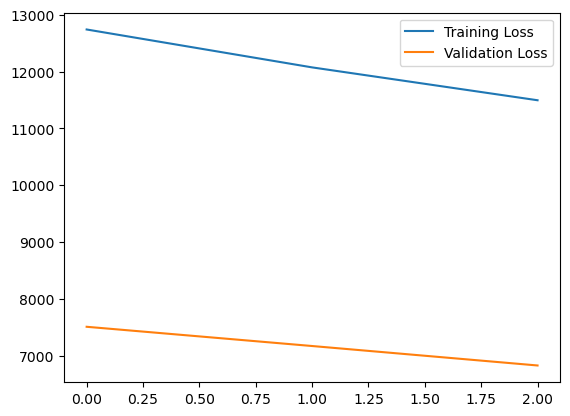

In [6]:
# Initialize lists to store the losses
train_losses = []
val_losses = []

# Train the MLP
for epoch in range(1000):  # 100 epochs
    modeld.train()  # Set the model to training mode
    optimizer.zero_grad()  # Reset the gradients
    train_outputs = modeld(train_features)  # Forward pass
    loss = criterion(train_outputs, train_labels)  # Compute the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    # Store the training loss
    train_losses.append(loss.item())

    # Print the loss for this epoch
    print(f'Epoch {epoch+1}/{100} - Training Loss: {loss.item()}')

    # Validate the MLP
    modeld.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track the gradients
        val_outputs = modeld(val_features)  # Forward pass
        val_loss = criterion(val_outputs, val_labels)  # Compute the loss

        # Store the validation loss
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            # Print the validation loss
            print(f'Epoch {epoch+1}/{100} - Validation Loss: {val_loss.item()}')

# Plot the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [10]:
# Save the model
torch.save(modeld.state_dict(), 'model_part_d.pth', )

In [92]:
# Convert the test dataset to PyTorch tensors and move them to the appropriate device
test_features = torch.tensor(test_features4, dtype=torch.float32, requires_grad=True).to(device)
test_labels = torch.tensor(test_labels4, dtype=torch.float32, requires_grad=True).to(device)
# Calculate the error function value for the test dataset
model = MLP().to(device)
model.load_state_dict(torch.load('model_part_d.pth', map_location=device))
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track the gradients
    test_outputs = model(test_features)  # Forward pass
    test_loss = criterion(test_outputs, test_labels)  # Compute the loss

# Print the test loss
print(f'Test Loss: {test_loss.item()}')

# Generate high-resolution images
high_res_images = []
for i in end_of_each_image4.keys():
    if i > 1:
        low_res_image_np = features[end_of_each_image4[i-1]:end_of_each_image4[i]]
    else:
        low_res_image_np = features[0:end_of_each_image4[1]]# Convert PIL Image to numpy array
    low_res_image_tensor = torch.tensor(low_res_image_np, dtype=torch.float32).to(device)
    high_res_image = model(low_res_image_tensor).cpu().detach().numpy()
    high_res_images.append(high_res_image)

Test Loss: 56.45225524902344


In [96]:
# Convert the numpy array to integer type
high_res_images_quantized = []
for i, (high_res_img, img) in enumerate(zip(high_res_images, images)):
    high_res_img = high_res_img.reshape(img.width, img.height, 3).astype(np.uint8)
    high_res_image_ = high_res_img.astype(np.uint8)
    high_res_images_quantized.append(high_res_image_)

# Convert the numpy array to a PIL Image
high_res_images_pil = [Image.fromarray(img).convert('RGB') for img in high_res_images_quantized]

In [97]:
eval_resolution(high_res_images, images)

Image 1 - SSIM: 0.06803588935034009, PSNR: 8.701954386368588
Image 2 - SSIM: 0.26432708700856244, PSNR: 11.181329611077
Image 3 - SSIM: 0.17685479612137905, PSNR: 13.004000789055151
Image 4 - SSIM: 0.08360395462102012, PSNR: 11.12928703065711
Image 5 - SSIM: 0.07711691684884585, PSNR: 10.22776810929608
Image 6 - SSIM: 0.17878920595659153, PSNR: 10.711464017884943
Image 7 - SSIM: 0.054088372408317854, PSNR: 8.188643233545033
Image 8 - SSIM: 0.1349946703637269, PSNR: 12.793923772524758
Image 9 - SSIM: 0.03628650625381224, PSNR: 10.999346446103885
Image 10 - SSIM: 0.23368880275121268, PSNR: 10.8659747225833


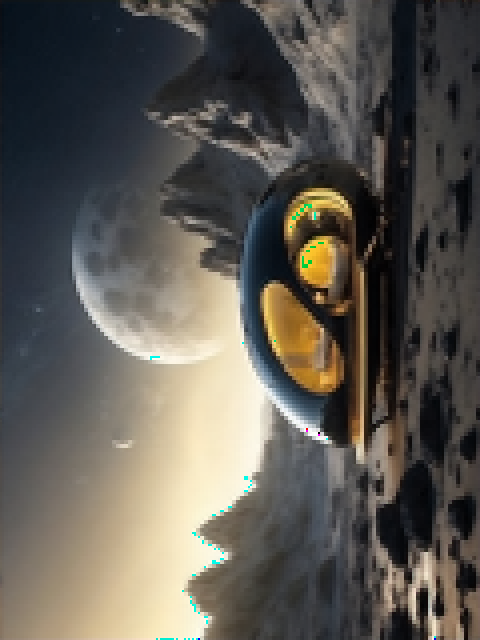

In [98]:
high_res_images_pil[0]

In [103]:
for i, high_res_images_pili in enumerate(high_res_images_pil):
    high_res_images_pili = high_res_images_pili.rotate(-90, expand=True)
    from PIL import ImageOps
    high_res_images_pili = ImageOps.mirror(high_res_images_pili)
    high_res_images_pili.save(f'{i + 1}_improving_resolution_four_times.jpg')